# **Comparative Analysis of Speech emotion recognition**

#### Why we chose SVM as one of our models to do the comparative analysis
- https://ieeexplore.ieee.org/document/6512793


### Importing necessary libraries

In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchaudio
import os
from torchaudio.transforms import Resample
import seaborn as sns

### Data-Loading and resampling
- We are loading the SAVEE dataset and resampling it to 16000kHz to ensure common sampling rate when we combine these datasets together

In [2]:
# Step 1: Load & Resample Audio
dataset_path = r"F:/CompAnalysis/SAVEE"
audio_files = [f for f in os.listdir(dataset_path) if f.endswith('.wav')]

target_sr = 16000  # Target sample rate

def load_audio_files(path, file_list, target_sr=None):
    audio_data = {}
    for file in file_list:
        file_path = os.path.join(path, file)
        signal, sr = librosa.load(file_path, sr=None)  # Load original sample rate
        if target_sr and sr != target_sr:
            signal = librosa.resample(signal, orig_sr=sr, target_sr=target_sr)
            sr = target_sr  # Update sample rate
        audio_data[file] = (signal, sr)
    return audio_data

# Load all audio files with resampling
audio_data = load_audio_files(dataset_path, audio_files, target_sr=16000)

- Visualising the Original Waveform and spectrogram

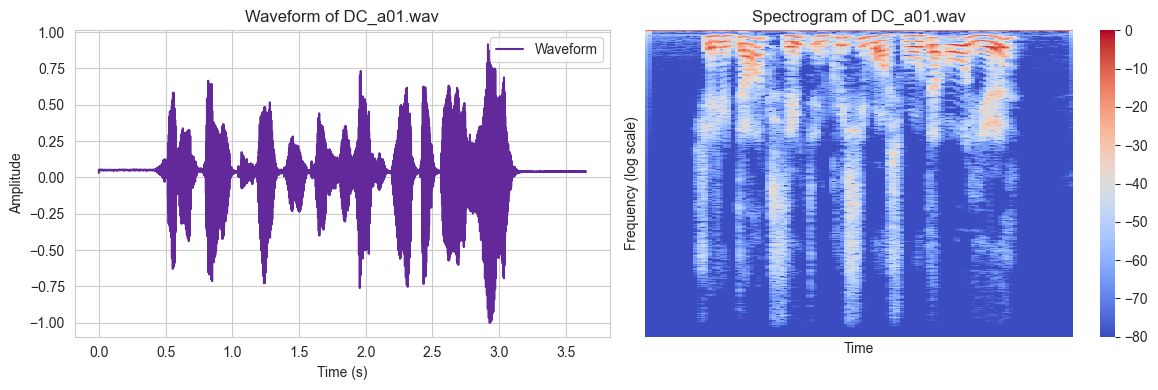

In [3]:
sns.set_style("whitegrid")

# Load the first audio file
first_file = audio_files[0]
signal, sr = audio_data[first_file]

# Create a side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Waveform plot with "forbes" palette color
sns.lineplot(
    x=np.linspace(0, len(signal) / sr, num=len(signal)), 
    y=signal, 
    label="Waveform", 
    color=sns.color_palette("dark:#8A2BE2", as_cmap=True)(0.6), 
    ax=axes[0]
)
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Amplitude")
axes[0].set_title(f"Waveform of {first_file}")
axes[0].legend()

# Spectrogram plot
D = librosa.amplitude_to_db(np.abs(librosa.stft(signal)), ref=np.max)
sns.heatmap(D, cmap="coolwarm", cbar=True, xticklabels=False, yticklabels=False, ax=axes[1])
axes[1].set_title(f"Spectrogram of {first_file}")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Frequency (log scale)")

plt.tight_layout()
plt.show()


- Using voice activity detection (VAD) we are trimming silence using adaptive thresholding, When playing around with the values we found out that 1.2 and 0.9 are the better values with 0.9 being even more accurate

In [4]:
def vad_trim(signal, sr):
    """Applies VAD trimming using adaptive thresholding."""
    rms_energy = librosa.feature.rms(y=signal, frame_length=1024, hop_length=512)[0]
    threshold = np.median(rms_energy) * 0.9  # Adaptive thresholding
    voiced_frames = rms_energy > threshold
    
    if np.any(voiced_frames):
        non_silent_indices = np.where(voiced_frames)[0]
        start = max(0, non_silent_indices[0] * 512)  # Convert frame index to sample index
        end = min(len(signal), non_silent_indices[-1] * 512)
        signal = signal[start:end]
    
    return signal

# Store VAD-trimmed audio separately
vad_audio_data = {file: (vad_trim(data[0], data[1]), data[1]) for file, data in audio_data.items()}


In [5]:
first_file = audio_files[0]
original_signal, sr = audio_data[first_file]
trimmed_signal = vad_trim(original_signal, sr)

print(f"Original Length: {len(original_signal)}, Trimmed Length: {len(trimmed_signal)}")

Original Length: 58365, Trimmed Length: 40960


- We are choosing the first file of the dataset to visualise our pre processing steps done
- We are plotting original waveform and VAD Trimmed waveform

In [6]:
# Pick a file for visualization
first_file = audio_files[0]
original_signal, sr = audio_data[first_file]  # Original
trimmed_signal, _ = vad_audio_data[first_file]  # Trimmed

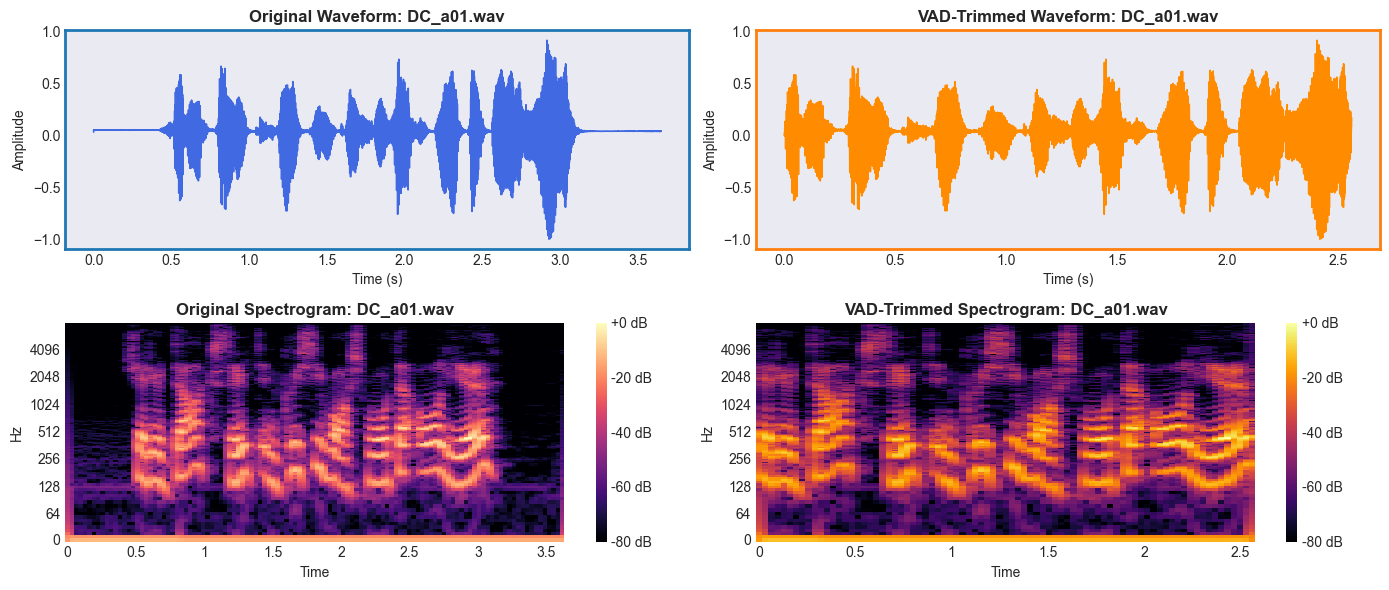

In [7]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set Seaborn style for aesthetics
sns.set_style("whitegrid")
plt.style.use("seaborn-v0_8-dark")

def plot_waveform_and_spectrogram(original, trimmed, sr, filename):
    """Visualizes original and trimmed waveforms & spectrograms side by side with borders only for waveforms."""
    fig, ax = plt.subplots(2, 2, figsize=(14, 6))

    # Time Axis
    time_orig = np.linspace(0, len(original) / sr, num=len(original))
    time_trim = np.linspace(0, len(trimmed) / sr, num=len(trimmed))

    # Define border colors for waveforms
    border_colors = ["#1f77b4", "#ff7f0e"]  # Blue for Original, Orange for Trimmed

    # Original Waveform (With Border)
    ax[0, 0].plot(time_orig, original, color="royalblue", linewidth=1.2)
    ax[0, 0].set_title(f"Original Waveform: {filename}", fontsize=12, fontweight="bold")
    ax[0, 0].set_xlabel("Time (s)")
    ax[0, 0].set_ylabel("Amplitude")

    # Trimmed Waveform (With Border)
    ax[0, 1].plot(time_trim, trimmed, color="darkorange", linewidth=1.2)
    ax[0, 1].set_title(f"VAD-Trimmed Waveform: {filename}", fontsize=12, fontweight="bold")
    ax[0, 1].set_xlabel("Time (s)")
    ax[0, 1].set_ylabel("Amplitude")

    # Original Spectrogram (No Border)
    D_original = librosa.amplitude_to_db(np.abs(librosa.stft(original)), ref=np.max)
    img1 = librosa.display.specshow(D_original, sr=sr, x_axis="time", y_axis="log", cmap="magma", ax=ax[1, 0])
    ax[1, 0].set_title(f"Original Spectrogram: {filename}", fontsize=12, fontweight="bold")
    fig.colorbar(img1, ax=ax[1, 0], format="%+2.0f dB")

    # Trimmed Spectrogram (No Border)
    D_trimmed = librosa.amplitude_to_db(np.abs(librosa.stft(trimmed)), ref=np.max)
    img2 = librosa.display.specshow(D_trimmed, sr=sr, x_axis="time", y_axis="log", cmap="inferno", ax=ax[1, 1])
    ax[1, 1].set_title(f"VAD-Trimmed Spectrogram: {filename}", fontsize=12, fontweight="bold")
    fig.colorbar(img2, ax=ax[1, 1], format="%+2.0f dB")

    # Add Borders ONLY for Waveforms
    for i in range(2):  # Only top row (waveforms)
        for spine in ax[0, i].spines.values():
            spine.set_edgecolor(border_colors[i])  # Set border color
            spine.set_linewidth(2)  # Set border thickness

    plt.tight_layout()
    plt.show()

# Pick a file for visualization
first_file = list(audio_data.keys())[0]
original_signal, sr = audio_data[first_file]
trimmed_signal, _ = vad_audio_data[first_file]

# Plot Pretty Visualizations
plot_waveform_and_spectrogram(original_signal, trimmed_signal, sr, first_file)


- For a Pytorch training loop we should convert it to a tensor. This is the input of the model ( Tensor )

In [8]:
torch_audio_data = {file: torch.tensor(data[0], dtype=torch.float32) for file, data in audio_data.items()}
print(f"Loaded {len(torch_audio_data)} audio files. Sample rate: {sr}")


Loaded 480 audio files. Sample rate: 16000


### Feature Extraction - extracting multiple features and saving them

- As this is a multifeature multimodal comparative analysis, We are extractine MFCC with 13 coefficients and MFCC with 40 coefficients and MFCC with Delta(Δ) First derivative and Double-Delta(Δ) Second Derivative

In [9]:
import librosa
import numpy as np
import os
import torch
import pickle

- The extracted features are MFCC 13 and 40 and Delta and Double Delta. They are saved in the features folder in the dataset path. 
- We are assesing all the frames and setting an optimal value for max_frames to ensure there is no unnecessary padding

In [10]:
import os
import numpy as np
import librosa
import pickle
from sklearn.preprocessing import StandardScaler

# Define dataset path
dataset_path = "F:/CompAnalysis/SAVEE"
feature_dir = os.path.join(dataset_path, "features")
os.makedirs(feature_dir, exist_ok=True)

# Define emotion label mapping (SAVEE encoding)
emotion_mapping = {
    "a": 0,  # Anger
    "d": 1,  # Disgust
    "f": 2,  # Fear
    "h": 3,  # Happiness
    "n": 4,  # Neutral
    "s": 5,  # Sadness
    "su": 6  # Surprise
}

# Get all audio files
audio_files = [f for f in os.listdir(dataset_path) if f.endswith(".wav")]

# Store frame lengths for analysis
frame_lengths = []

# Analyze dataset to determine max frame length
for file in audio_files:
    file_path = os.path.join(dataset_path, file)
    signal, sr = librosa.load(file_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=40)
    frame_lengths.append(mfcc.shape[1])

# 95th percentile frame length to avoid outliers
max_frames = int(np.percentile(frame_lengths, 95))
print(f"Optimal frame length: {max_frames}")

# Initialize feature storage
features_list, labels, filenames = [], [], []

def pad_or_truncate(feature, max_frames):
    """ Pad or truncate feature to max_frames length """
    if feature.shape[1] < max_frames:
        pad_width = max_frames - feature.shape[1]
        return np.pad(feature, ((0, 0), (0, pad_width)), mode='constant')
    else:
        return feature[:, :max_frames]

# Extract Features
for file in audio_files:
    file_path = os.path.join(dataset_path, file)
    
    # Extract emotion label from filename
    emotion_code = file.split("_")[1][0]
    if emotion_code not in emotion_mapping:
        continue
    label = emotion_mapping[emotion_code]

    # Load audio
    signal, sr = librosa.load(file_path, sr=16000)

    # Extract MFCC-40
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=40)
    mfcc = pad_or_truncate(mfcc, max_frames)

    # Extract Mel-Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=40)
    mel_spec = librosa.power_to_db(mel_spec)  # Convert to dB
    mel_spec = pad_or_truncate(mel_spec, max_frames)

    # Normalize Features
    scaler = StandardScaler()
    mfcc = scaler.fit_transform(mfcc.T).T
    mel_spec = scaler.fit_transform(mel_spec.T).T

    # Combine Features (MFCC + Mel-Spectrogram)
    combined_features = np.vstack([mfcc, mel_spec])  # Shape: (80, max_frames)

    # Store Features and Labels
    features_list.append(combined_features)
    labels.append(label)
    filenames.append(file)

# Convert lists to arrays
features = np.array(features_list)  # Shape: [num_samples, 80, max_frames]
labels = np.array(labels)

# Save Features and Labels
np.save(os.path.join(feature_dir, "mfcc_mel.npy"), features)
np.save(os.path.join(feature_dir, "labels.npy"), labels)

# Save Filenames
with open(os.path.join(feature_dir, "filenames.pkl"), "wb") as f:
    pickle.dump(filenames, f)

print(f"Feature Extraction Complete: {len(features)} Samples Saved.")


Optimal frame length: 184
Feature Extraction Complete: 480 Samples Saved.


### Prepare the Dataloader and set up training operations

####  - Dataset Preparation for SER  

- Feature Extraction: Three types of MFCC features extracted:  
  - MFCC-13 (Base)  
  - MFCC-ΔΔ (Delta & Delta-Delta)  
  - MFCC-40 (Extended)  

- Dataset Class (`SERDataset`):  
  - Stores features and labels in PyTorch tensors.  
  - Supports dynamic feature selection (`mfcc_13`, `mfcc_dd`, `mfcc_40`).  

- Train-Test Split:  
  - 80% training, 20% testing (Stratified).  

- Dataloaders:  
  - train_loader & test_loader for batch processing (Batch size: 32).  

Feature type can be switched easily before training.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load extracted features and labels
features = np.load(r"F:\CompAnalysis\SAVEE\features\mfcc_mel.npy")  # Shape: [num_samples, 168, time_steps]
labels = np.load(r"F:\CompAnalysis\SAVEE\features\labels.npy")  # Shape: [num_samples]

# Reshape features for normalization (flatten time_steps)
num_samples, num_features, time_steps = features.shape
features_reshaped = features.reshape(num_samples, -1)  # Shape: [num_samples, 168 * time_steps]

# Apply Z-score normalization
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features_reshaped)

# Reshape back to original form
features_normalized = features_normalized.reshape(num_samples, num_features, time_steps)

# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    features_normalized, labels, test_size=0.2, random_state=42, stratify=labels
)

class SERDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create dataset instances
train_dataset = SERDataset(X_train, y_train)
test_dataset = SERDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train set size: {len(train_dataset)}, Test set size: {len(test_dataset)}")


Train set size: 384, Test set size: 96


## Model Training and Evaluation.

- First we are training the model on MFCC 13 Features

Test Accuracy: 0.5312
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.42      0.59        12
           1       0.75      0.25      0.38        12
           2       1.00      0.17      0.29        12
           3       0.38      0.25      0.30        12
           4       0.68      0.88      0.76        24
           5       0.37      0.71      0.49        24

    accuracy                           0.53        96
   macro avg       0.70      0.44      0.47        96
weighted avg       0.65      0.53      0.51        96



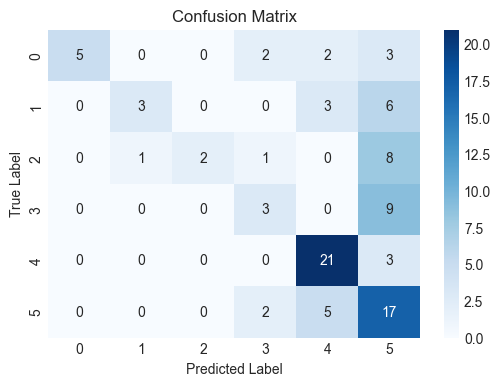

In [16]:
import numpy as np
import librosa
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load extracted features and labels
features = np.load(r"F:\CompAnalysis\SAVEE\features\mfcc_mel.npy")  # Shape: [num_samples, 168, time_steps]
labels = np.load(r"F:\CompAnalysis\SAVEE\features\labels.npy")   # Shape: [num_samples]

# Flatten features for SVM (convert to 2D)
X = features.reshape(features.shape[0], -1)  # Shape: [num_samples, num_features * time_steps]
y = labels

# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features (Z-score normalization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM model with optimal hyperparameters
best_svm = SVC(C=10, gamma="scale", kernel="rbf")  
best_svm.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = best_svm.predict(X_test_scaled)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Visualization
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()